# Set up

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/242B_final_project') # customize this line to your working directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F
from torchvision.models import resnet50

import PIL.Image
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

In [ ]:
path = "/content/drive/MyDrive/242B_final_project/data/"

In [ ]:
lfw_allnames = pd.read_csv(f"{path}lfw_allnames.csv")
pairs = pd.read_csv(f"{path}pairs.csv")

matchpairsDevTest = pd.read_csv(f"{path}matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv(f"{path}matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv(f"{path}mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv(f"{path}mismatchpairsDevTrain.csv")

# Data Overview

## Data Format

In [ ]:
matchpairsDevTrain.head()

,name,imagenum1,imagenum2
0,Aaron_Peirsol,1,2
1,Aaron_Peirsol,3,4
2,Aaron_Sorkin,1,2
3,Abdel_Nasser_Assidi,1,2
4,Abdullah,1,3


In [ ]:
mismatchpairsDevTrain.head()

,name,imagenum1,name.1,imagenum2
0,AJ_Cook,1,Marsha_Thomason,1
1,Aaron_Sorkin,2,Frank_Solich,5
2,Abdel_Nasser_Assidi,2,Hilary_McKay,1
3,Abdoulaye_Wade,4,Linda_Dano,1
4,Abdul_Rahman,1,Magui_Serna,1


In [ ]:
pairs.head()

,name,imagenum1,imagenum2,Unnamed: 3
0,Abel_Pacheco,1,4,NaN
1,Akhmed_Zakayev,1,3,NaN
2,Akhmed_Zakayev,2,3,NaN
3,Amber_Tamblyn,1,2,NaN
4,Anders_Fogh_Rasmussen,1,3,NaN


In [ ]:
lfw_allnames.head()

,name,images
0,AJ_Cook,1
1,AJ_Lamas,1
2,Aaron_Eckhart,1
3,Aaron_Guiel,1
4,Aaron_Patterson,1


## Data Description

### lfw_allnames

In [ ]:
lfw_allnames

,name,images
0,AJ_Cook,1
1,AJ_Lamas,1
2,Aaron_Eckhart,1
3,Aaron_Guiel,1
4,Aaron_Patterson,1
...,...,...
5744,Zorica_Radovic,1
5745,Zulfiqar_Ahmed,1
5746,Zumrati_Juma,1
5747,Zurab_Tsereteli,1


In [ ]:
lfw_allnames.sort_values(by="images", ascending=False)
lfw_allnames.describe()

,images
count,5749.000000
mean,2.301792
std,9.016410
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,530.000000


In [ ]:
# Display the count of unique values in the "name" column
unique_name_count = lfw_allnames['name'].nunique()
print("Count of unique names:", unique_name_count)
print("Count of all data:", lfw_allnames["images"].sum())

Count of unique names: 5749
Count of all data: 13233


In [ ]:
# People with two or more images
df_2_ppl = lfw_allnames[lfw_allnames["images"] >= 2]
print("# of people with two or more images:", len(df_2_ppl))
df_2_ppl

# of people with two or more images: 1680


,name,images
5,Aaron_Peirsol,4
7,Aaron_Sorkin,2
13,Abdel_Nasser_Assidi,2
14,Abdoulaye_Wade,4
18,Abdullah,4
...,...,...
5736,Zhang_Ziyi,4
5738,Zhu_Rongji,9
5739,Zico,3
5740,Zinedine_Zidane,6


### matchpairsDevTrain

In [ ]:
matchpairsDevTrain.describe()

,imagenum1,imagenum2
count,1100.000000,1100.000000
mean,2.532727,5.484545
std,5.340952,11.759833
min,1.000000,2.000000
25%,1.000000,2.000000
50%,1.000000,3.000000
75%,2.000000,5.000000
max,120.000000,212.000000


### mismatchpairsDevTrain

In [ ]:
mismatchpairsDevTrain.describe()

,imagenum1,imagenum2
count,1100.000000,1100.000000
mean,2.150000,1.520909
std,16.300696,1.760066
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,407.000000,27.000000


### matchpairsDevTest

In [ ]:
matchpairsDevTest.describe()

,imagenum1,imagenum2
count,500.000000,500.000000
mean,2.634000,5.178000
std,4.233662,7.419732
min,1.000000,2.000000
25%,1.000000,2.000000
50%,1.000000,3.000000
75%,2.000000,5.000000
max,41.000000,108.000000


### mismatchpairsDevTest

In [ ]:
mismatchpairsDevTest.describe()

,imagenum1,imagenum2
count,500.000000,500.000000
mean,1.454000,1.524000
std,2.185735,1.943445
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,40.000000,23.000000


## Check Missing Values

In [ ]:
# Missing values check
print(matchpairsDevTrain.isnull().sum())
print(matchpairsDevTest.isnull().sum())
print(mismatchpairsDevTrain.isnull().sum())
print(mismatchpairsDevTest.isnull().sum())

name         0
imagenum1    0
imagenum2    0
dtype: int64
name         0
imagenum1    0
imagenum2    0
dtype: int64
name         0
imagenum1    0
name.1       0
imagenum2    0
dtype: int64
name         0
imagenum1    0
name.1       0
imagenum2    0
dtype: int64


No missing values

## Image Exploration

### Read single image

Note that the use of VGG16 network implies the need of having images with size  224*224. The original image is a 250x250 jpg. Thus, we need to transform the image.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Function to load and visualize an image
def load_image(img_path):
    img = PIL.Image.open(img_path)
    img = img.convert('RGB')
    img = transform(img)
    return img

def visualize_image(image_tensor):
    image_numpy = image_tensor.numpy()
    image_numpy = image_numpy.transpose((1, 2, 0)) # Transpose the dimensions to (height, width, channels)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_numpy = (image_numpy * std) + mean
    image_numpy = np.clip(image_numpy, 0, 1)  # Clip the values to be within [0, 1]
    plt.imshow(image_numpy)
    plt.axis('off')
    plt.show()

In [ ]:
image_path = "/content/drive/MyDrive/242B_final_project/data/lfw-deepfunneled/lfw-deepfunneled/"

In [ ]:
# Test the load_image function
load_image(f"{image_path}Aaron_Eckhart/Aaron_Eckhart_0001.jpg")

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

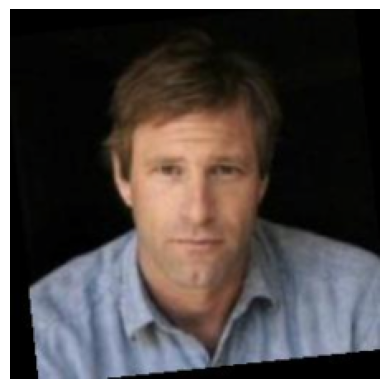

In [ ]:
visualize_image(load_image(f"{image_path}Aaron_Eckhart/Aaron_Eckhart_0001.jpg"))

### Read pairs

In [ ]:
# Function to create pairs of images and labels
def create_pairs(df, is_match):
    pairs = []
    labels = []
    for _, row in df.iterrows():
        # Get the name and image numbers for the first image
        name1 = row['name']
        imagenum1 = row['imagenum1']
        # Get the name and image numbers for the second image
        if is_match:
            # For matched pairs, both images are of the same person
            name2 = name1
            imagenum2 = row['imagenum2']
            label = 1
        else:
            # For mismatched pairs, the images are of different people
            name2 = row['name.1'] if 'name.1' in df.columns else row['name']
            imagenum2 = row['imagenum2']
            label = 0
        # Load images
        img1_path = f"{image_path}{name1}/{name1}_{imagenum1:04d}.jpg"
        img2_path = f"{image_path}{name2}/{name2}_{imagenum2:04d}.jpg"
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)
        # Append the pair and label to the respective lists
        pairs.append([img1, img2])
        labels.append(label)

    # Convert the lists to NumPy arrays
    pairs = np.array(pairs)
    labels = np.array(labels)

    return pairs, labels.astype("float32")

In [ ]:
train_matched_pairs, train_matched_labels = create_pairs(matchpairsDevTrain, is_match=True)
train_mismatched_pairs, train_mismatched_labels = create_pairs(mismatchpairsDevTrain, is_match=False)
test_matched_pairs, test_matched_labels = create_pairs(matchpairsDevTest, is_match=True)
test_mismatched_pairs, test_mismatched_labels = create_pairs(mismatchpairsDevTest, is_match=False)

In [ ]:
def imshow(tensor, ax, title=None):
    # Assume tensor is in CxHxW, PyTorch format
    tensor = tensor.permute(1, 2, 0)  # Change to HxWxC
    # Normalize to [0, 1] for float types or convert to integer
    if tensor.dtype == torch.float32:
        tensor = torch.clamp(tensor, 0, 1)  # Clamp to ensure values are within [0, 1]
    image = tensor.numpy()
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')

In [ ]:
def imshow(array, ax, title=None):
    # Assume array is in CxHxW format
    array = array.transpose(1, 2, 0)  # Change to HxWxC
    # Normalize to [0, 1] for float types or convert to integer
    if array.dtype == np.float32 or array.dtype == np.float64:
        ax.imshow(array.clip(0, 1))
    else:
        ax.imshow(array)
    if title:
        ax.set_title(title)

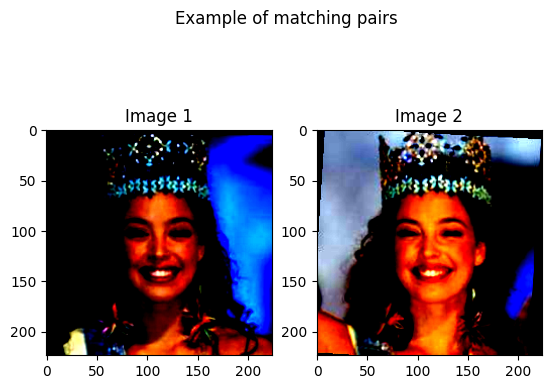

In [ ]:
# Matching pairs
fig, (ax1, ax2) = plt.subplots(1, 2)
img1, img2 = train_matched_pairs[100]

imshow(img1, ax1, 'Image 1')
imshow(img2, ax2, 'Image 2')
plt.suptitle('Example of matching pairs')
plt.show()

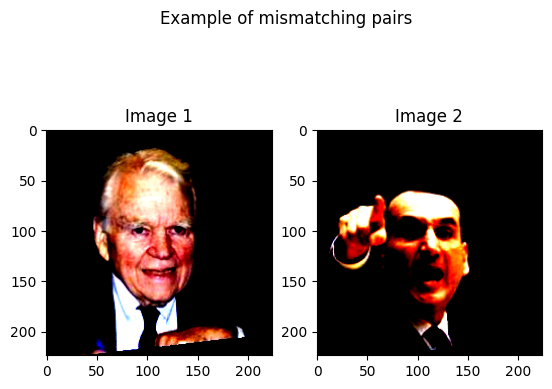

In [ ]:
# Mismatching pairs
fig, (ax1, ax2) = plt.subplots(1, 2)
img1, img2 = train_mismatched_pairs[100]

imshow(img1, ax1, 'Image 1')
imshow(img2, ax2, 'Image 2')
plt.suptitle('Example of mismatching pairs')
plt.show()

## Dataloader

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, matched_pairs, matched_labels, mismatched_pairs, mismatched_labels):
        self.pairs = np.concatenate((matched_pairs, mismatched_pairs), axis=0)
        self.labels = np.concatenate((matched_labels, mismatched_labels), axis=0)

        # Shuffle the data
        indices = np.arange(len(self.pairs))
        random.shuffle(indices)
        self.pairs = self.pairs[indices]
        self.labels = self.labels[indices]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img1 = self.pairs[idx][0]
        img2 = self.pairs[idx][1]
        label = self.labels[idx]

        return img1, img2, label

In [ ]:
train_dataset = SiameseDataset(train_matched_pairs, train_matched_labels,
                                train_mismatched_pairs, train_mismatched_labels)

test_dataset = SiameseDataset(test_matched_pairs, test_matched_labels,
                               test_mismatched_pairs, test_mismatched_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# Function to visualize a pair of images and their label
def visualize_pair(img1, img2, label):
    img1, img2 = img1.permute(1, 2, 0), img2.permute(1, 2, 0)
    if img1.dtype == torch.float32:
        img1 = torch.clamp(img1, 0, 1)
    img1 = img1.numpy()
    if img2.dtype == torch.float32:
        img2 = torch.clamp(img2, 0, 1)
    img2 = img2.numpy()
    # Display the images
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title('Image 2')
    plt.axis('off')
    # Set the title based on the label
    if label == 1:
        plt.suptitle('Matching pair')
    else:
        plt.suptitle('Mismatching pair')

    plt.show()

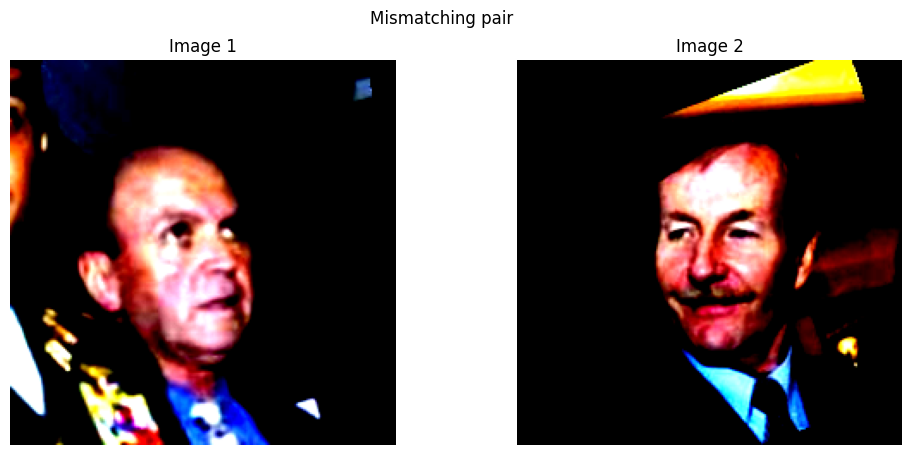

In [ ]:
for img1, img2, label in train_loader:
    visualize_pair(img1[2], img2[2], label[2])
    break